# Nested Sampler Introduction

by Thea McKenna & Sarah Blunt, with advice & wisdom from Josh Speagle (2024) 

Here, we will explain how to sample an orbit posterior using nested sampling from the `dynesty` package. An advantage of nested sampling is that it computes the evidence and posterior at the same time. To compute the evidence, Dynesty first uses live points to make iso-likelihood contours with probability greater than that of the previous contour. It then takes the integral of these contour shells and calculates prior “volumes” of these shells. As each contour is made, the live point with the least probability is removed (it “dies”), and it is replaced with a new live point sampled from the prior, which must have a higher probability. `dynesty` then uses these “dead” points to approximate the evidence integral by weighting each point and summing them. To estimate the posterior, dynesty then uses the calculated “dead” point weighting and evidence to get its importance weight, or the probability of the parameter set. For more info on how nested sampling works in `dynesty`, go to their [website](https://dynesty.readthedocs.io/en/stable/index.html).

In this tutorial, we will demonstrate how to generate a synthetic data set with a user-controlled orbit fraction (fraction of orbit covered by the synthetic data points) to feed into the nested sampler. We will also show plots using the sampler results from `dynesty` and save these results.


# Generate Synthetic Data
We generate synthetic data using the `generate_synthetic_data` function in `orbitize.system` to feed into the nested sampler. This function sets ground truth values for all of the parameters, the desired fractional orbit coverage, the number of observations, and the desired observational uncertainty. The observations are uniformly spaced synthetic data points covering the years 2001-2003 such that the orbital period and semi-major axis are determined by selecting the orbital fraction. A three year period is used for all orbits, so that for smaller orbit fraction, the orbit has a larger semi-major axis. The function then adds Gaussian noise to the observations to make them more realistic. This approach simulates similar observing strategies for orbits of varying lengths.

      epoch        object        quant1       ... quant_type instrument
------------------ ------ ------------------- ... ---------- ----------
           51550.0      1   26.80749409680015 ...      radec      defrd
 51587.93103448276      1  29.108164753506628 ...      radec      defrd
51625.862068965514      1  48.910894541835965 ...      radec      defrd
51663.793103448275      1   48.89113297812603 ...      radec      defrd
51701.724137931036      1  54.902728166363005 ...      radec      defrd
 51739.65517241379      1 -3.2294339867550867 ...      radec      defrd
 51777.58620689655      1    6.75909265680874 ...      radec      defrd
 51815.51724137931      1 -47.876270799215646 ...      radec      defrd
 51853.44827586207      1  -63.97156459001942 ...      radec      defrd
51891.379310344826      1  -93.38916349992081 ...      radec      defrd
               ...    ...                 ... ...        ...        ...
 52270.68965517241      1 -168.59492862364965 ...      radec    

<ErrorbarContainer object of 3 artists>

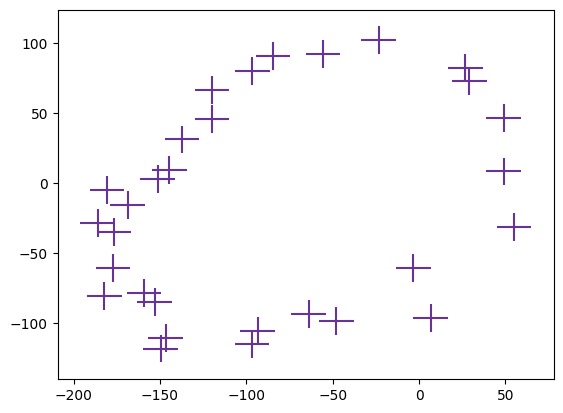

In [1]:
import orbitize
from orbitize import read_input, system, priors, sampler
import matplotlib.pyplot as plt
from orbitize.system import generate_synthetic_data
import numpy as np

np.random.seed(1)

# generate data
plx = 60.0  # [mas]
mtot = 1.2  # [M_sol]
orbit_frac = 95.0
ecc = 0.5
inc = np.pi / 4
aop = np.pi / 4
pan = np.pi / 4
tau = 0.8
unc = 10  # [mas]

data_table, sma = generate_synthetic_data(
    orbit_frac,
    mtot,
    plx,
    num_obs=30,
    inc=inc,
    tau=tau,
    unc=unc,
    lan=pan,
    argp=aop,
    ecc=ecc,
)

# initialize orbitize.system.System object
num_secondary_bodies = 1
sys = system.System(
    num_secondary_bodies, data_table, mtot, plx, restrict_angle_ranges=True
)
print(data_table)
lab = sys.param_idx

# plot the generated data
plt.figure()
plt.errorbar(
    data_table["quant1"],
    data_table["quant2"],
    data_table["quant1_err"],
    data_table["quant2_err"],
    ls="",
    color="rebeccapurple",
)

# Running the Dynesty Sampler
`dynesty's` nested sampler has multiple prior bound shape options, as well as a static and dynamic nested sampler, more details of which can be found [here](https://dynesty.readthedocs.io/). These can also be configured in `run_sampler` keywords. Here we stick with the default options of a static sampler and 'multi' prior bound shape.

In [2]:
# fix the values of semimajor axis and argument of periastron to speed up convergence for ease of tutorial use
sys.sys_priors[lab["sma1"]] = sma
sys.sys_priors[lab["aop1"]] = aop

threads = 8  # number of parallel threads to use
nested_sampler = sampler.NestedSampler(sys)
samples, num_iter = nested_sampler.run_sampler(num_threads=threads, static=False)

iter: 18941 | batch: 6 | bound: 8 | nc: 1 | ncall: 78925 | eff(%): 23.720 | loglstar: -223.183 < -217.852 < -219.047 | logz: -234.384 +/-  0.111 | stop:  0.892                                       

# Plotting
Full plotting capabilities of orbitize (including advanced corner and orbit plots) can be found in the [orbitize plotting tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/Plotting_tutorial.html).

Here, we will plot the posterior samples from dynesty against the ground truth variables used to generate the synthetic data set.

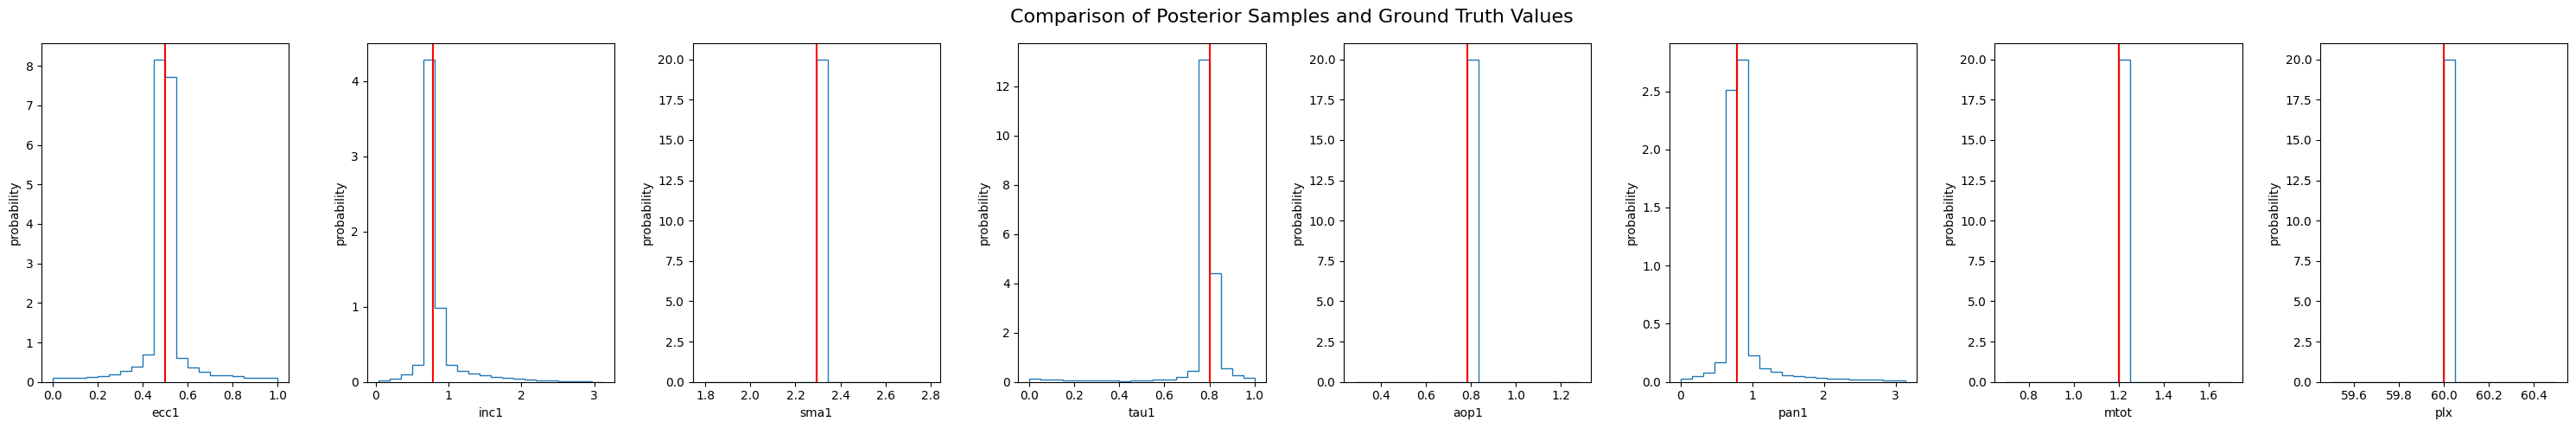

In [3]:
# plot posterior samples of each parameter with the groound truth value for comparison
fig, ax = plt.subplots(1, 8, figsize=(30, 5))
labels = ["ecc1", "inc1", "sma1", "tau1", "aop1", "pan1", "mtot", "plx"]
truth = [ecc, inc, sma, tau, aop, pan, mtot, plx]
for i in range(0, 8):
    ax[i].hist(
        nested_sampler.results.post[:, lab[labels[i]]],
        bins=20,
        density=True,
        histtype="step",
    )
    ax[i].set_ylabel("probability")
    ax[i].set_xlabel(labels[i])
    ax[i].axvline(truth[i], color="red")
fig.suptitle("Comparison of Posterior Samples and Ground Truth Values", fontsize=16)
plt.tight_layout()

We can also visualize the run using `dynesty` plotting tools (see [this page](https://dynesty.readthedocs.io/en/stable/dynamic.html)) for info about interpreting these plots.

/home/sblunt/miniconda3/envs/python3.12/lib/python3.12/site-packages/dynesty/plotting.py:706: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min(x), max(x)])
/home/sblunt/miniconda3/envs/python3.12/lib/python3.12/site-packages/dynesty/plotting.py:749: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])


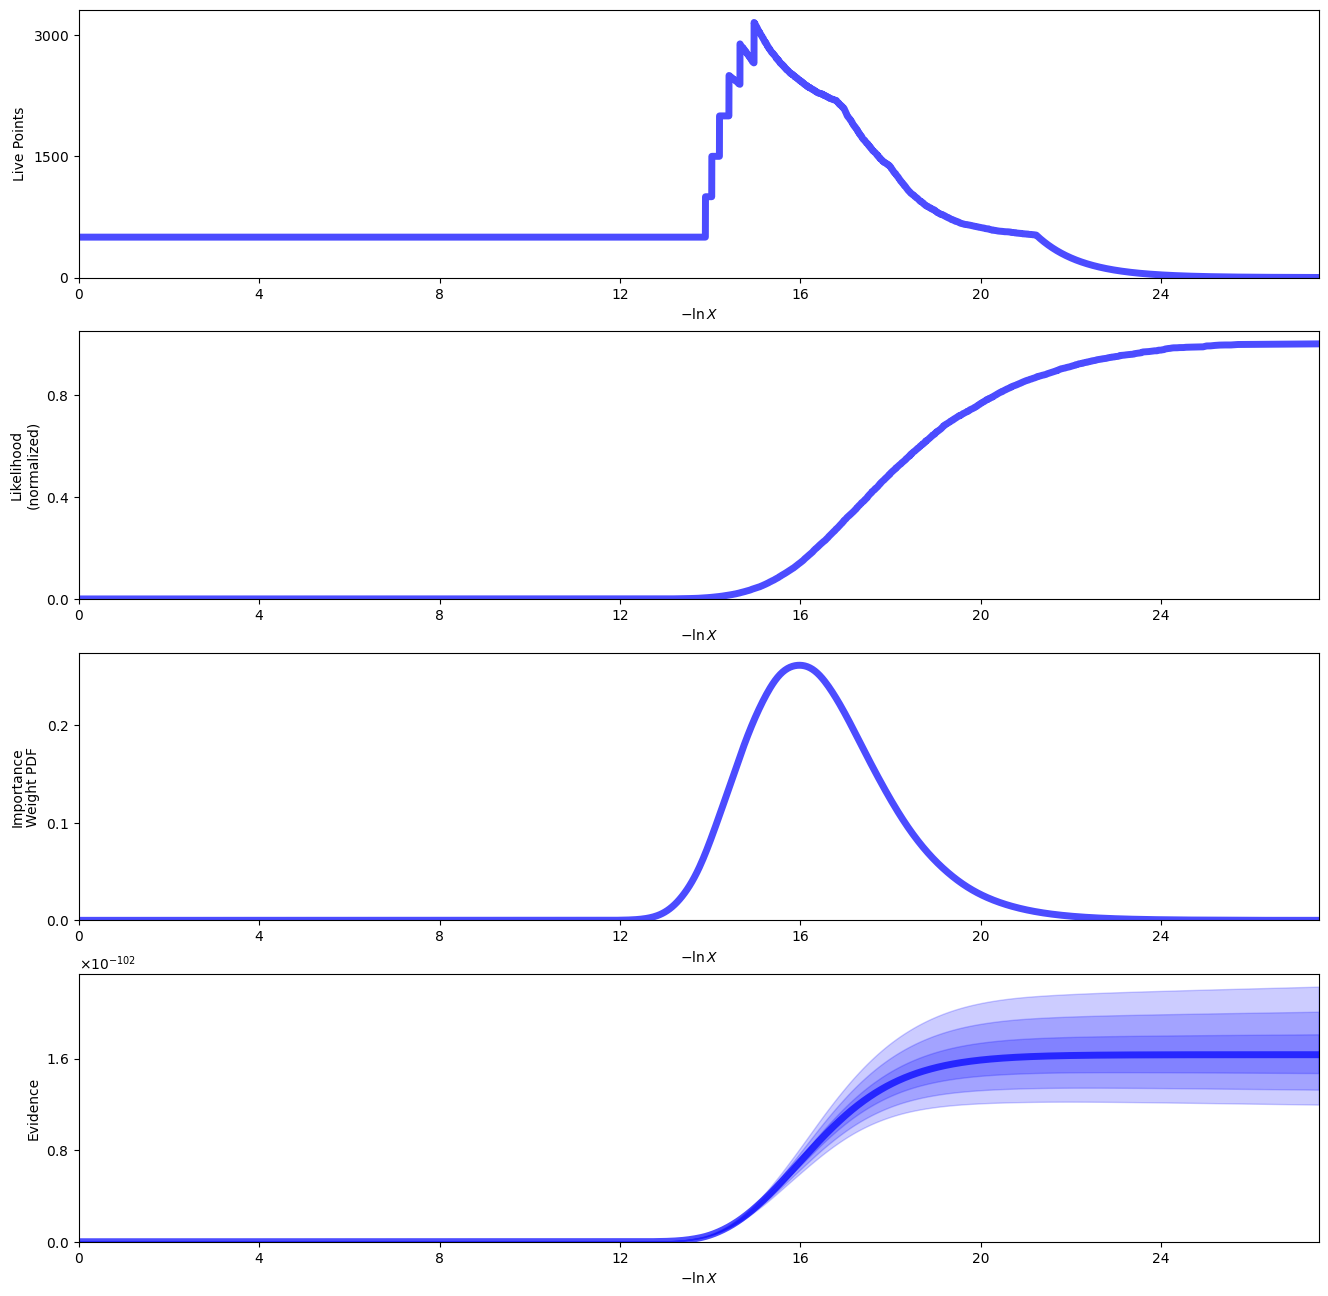

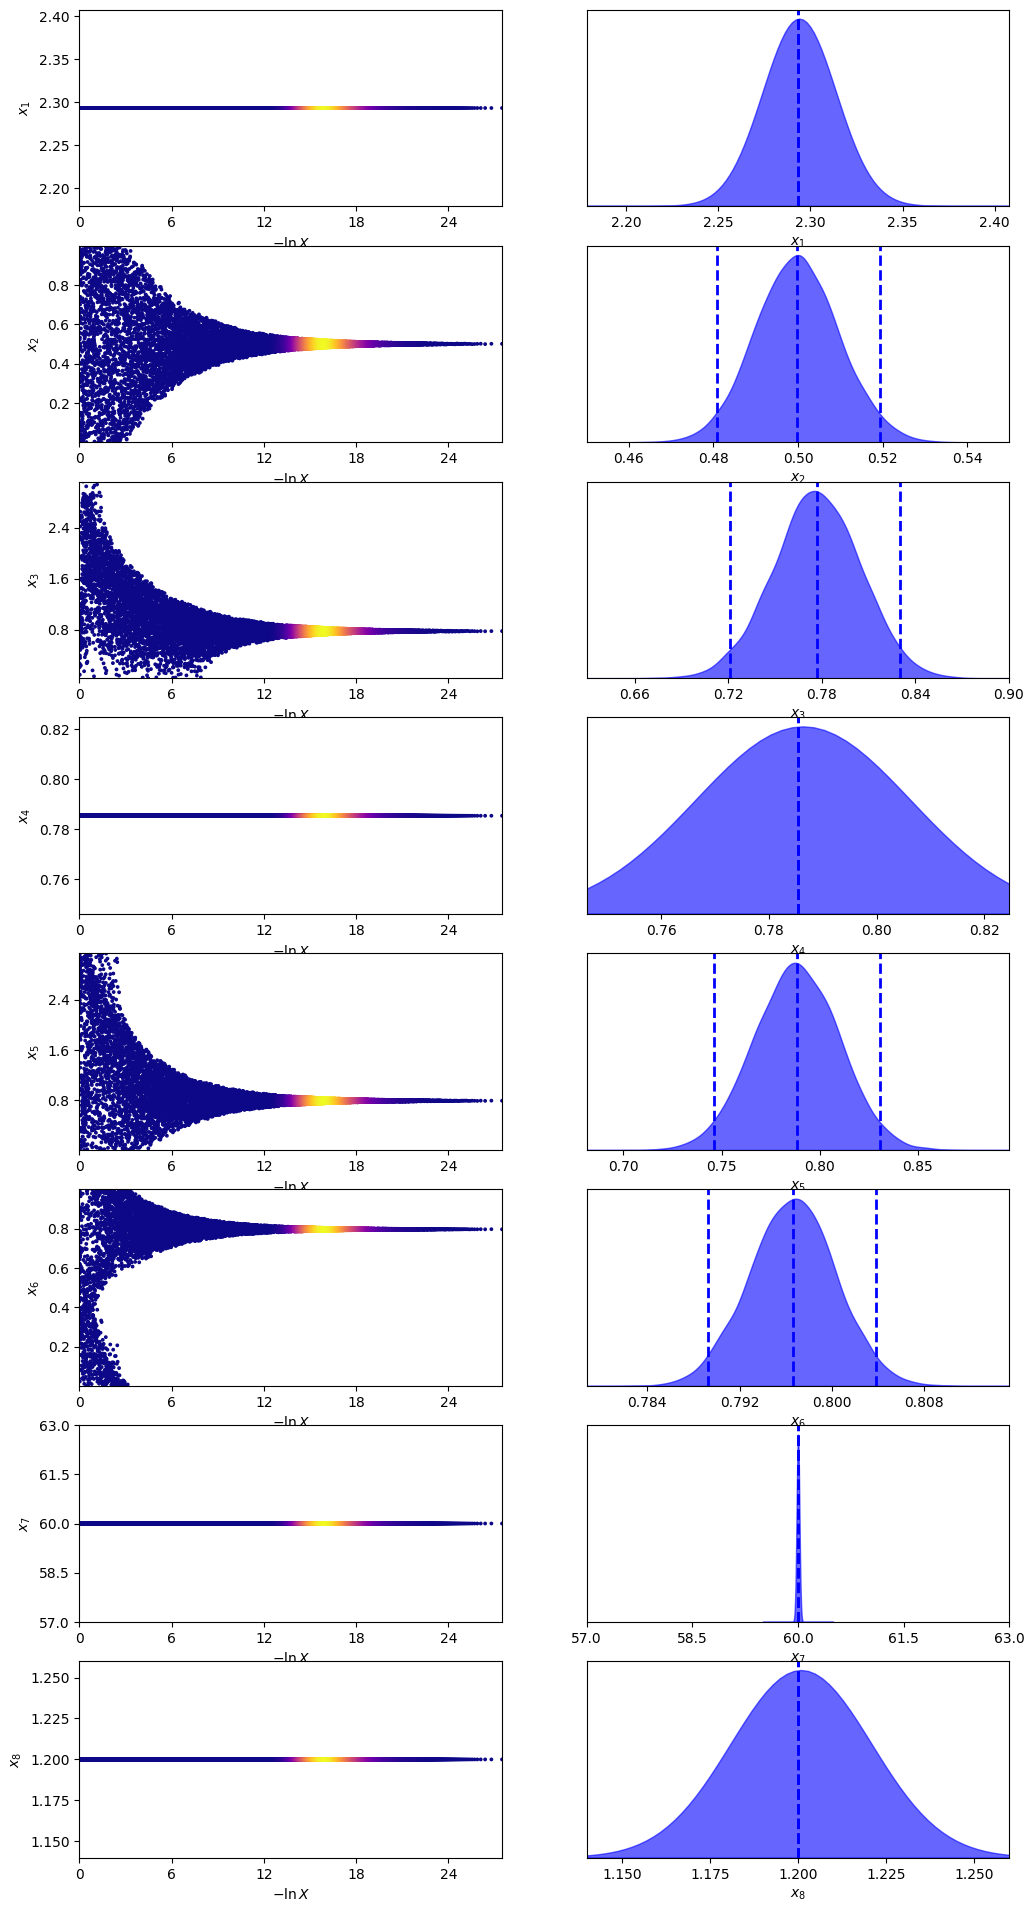

In [6]:
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(nested_sampler.dynesty_sampler.results)
fig, axes = dyplot.traceplot(nested_sampler.dynesty_sampler.results)

# Tips for Faster Convergence

Here are some tips that (in our experience) will help your sampler converge more quickly:

1. Set the `orbitize.system.System.restrict_angle_ranges` keyword. This sets the prior on $\Omega$ (position angle of nodes) to be 0-$\pi$, rather than the usual 0-$2\pi$ (unless you have data in addition to your relative astrometry, like RV measurements, that will uniquely identify one of the two degenerate $\Omega$ peaks.)

2. We recommend restricting your prior on semimajor axis as much as possible. A good rule of thumb is as follows:

- step 1: fit a circular orbit (fix e=0, or chi-by-eye) to your data, and note the semimajor axis
- step 2: set your semimajor axis prior limits between 0 and 5 x your circular orbit solution
- step 3: once your fit is finished, check if your semimajor axis posterior doesn't drop off sharply to zero at the upper bound. If it does, repeat the fit with a wider prior.

**It's important to note that this method isn't reliable for computing the Bayesian evidence, just for computing the posterior!**

3. Parallelization (which you can use by passing `num_threads`>1 into `nested_sampler.run_sampler()`) helps, so use it if you can!

# Saving Results

In [ ]:
# save results in .hdf5 format
filename = "myposterior.hdf5"
nested_sampler.results.save_results(filename)